# Diagonalizing Matrix Flows

Jupyter notebook by [Klas Modin](https://klasmodin.wordpress.com) for numerical simulation of diagonalizing matrix flows. The code is heavily based on [quflow](https://github.com/klasmodin/quflow) for the numerical discretization of transport equations on the sphere.

In [72]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import h5py
import matplotlib
import quflow as qf
from scipy.interpolate import interp1d
import os

# Specify matplotlib parameters
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.style.use('dark_background')

# Set higher resolution images for macbook screen
%config InlineBackend.figure_format='retina'

# Theory

We give here a (very) brief description of the connection between the incompressible porous medium (IPM) equation and the Toda flow described in [a paper by Khesin and Modin](https://arxiv.org/abs/2207.10214).

We are interested in gradient flows on the Lie group $\mathrm{U}(N)$ for energy functionals of the form 
$$
    E(G) = F(G W_0 G^\dagger)
$$
for some $F:\mathfrak{u}(N)\to \mathbb{R}$.
We can represent such flows as isospectral flows on $\mathfrak{u}(N)$ given by
$$
    \dot W = [P, W], \quad P =  -A^{-1}[dF(W), W]
$$
where $A:\mathfrak{u}(N)\to \mathfrak{u}(N)$ is the inertia operator defining the right-invariant metric on $\operatorname{U}(N)$ for which the gradient is taken.
In the limit $N\to \infty$ we obtain (at least formally via the classical limit in quantum physics) a gradient flow on the group of area-preserving diffeomorphisms $\operatorname{Diff}_\mu(S^2)$, expressed as an orbit-preserving flow on $\mathfrak{g}^* \simeq C^\infty_0(S^2)$
$$
    \dot\omega = \{\psi, \omega\}, \quad \psi = A^{-1}\{\frac{\delta F}{\delta \omega},\omega \}
$$
where $\{ \cdot,\cdot\}$ is the Poisson bracket on $C^\infty(S^2)$.

Returning to finite dimension, for IPM and Toda we take
$$
    F(W) = \frac{1}{2}\operatorname{tr}(V W)
$$
for $V\in\mathfrak{u}(N)$ diagonal with equidistant entries $-i$ to $i$.
Since $F$ is linear $dF(W)$ is constant, given by $V$.
For Toda $A = id$ and for IPM $A=\Delta_N$, which is the Hoppe-Yau Laplacian. 
The equation $\Delta_N P = W$ is solved in `quflow` with `P = qf.solve_poisson(W)`. To solve the entire flows we need to implement functions the evaluate the generator $P\in\mathfrak{u}(N)$ (called `hamiltonian` in `quflow`) as a function of $W$. Both the IPM and the Toda flows strive to align the matrix $W$ with $N$ without changing its spectrum. This yields flows that diagonalize $W$ while also aiming to order the eigenvalues along the diagonal.

If one is only interested in diagonalizing a matrix, but not so much in ordering the eigenvalues, a better suited functional is 
$$
    F(W) = -\frac{1}{2}\sum_{i=1}^N |W_{ii}|^2, 
$$
which is minimized on the isospectral orbit if and only if $W$ is diagonal. However, there is no drive towards making the elements sorted.
The derivative of this $F$ is given by $dF(W) = -D(W)$ where $D(W)$ denotes the diagonal part of $W$.
Thus, we obtain the flow
$$
    \dot W = [P, W], \quad P =  A^{-1}[D(W), W]
$$
for either $A=id$ (Toda-like) or $A=\Delta_N$ (IPM-like).

# Generate random initial conditions

Here we generate a random tridiagonal matrix of the form for classical Toda flows: $W_0 = \mathrm{i}L_0$, where $L_0$ is a symmetric tridiagonal real matrix.

In [2]:
# Size of matrices
N = 256

# Size of vector to generate random a and b vectors
# (smaller value gives smoother initial vorticity function)
n = 8

# Generate smooth random vector a for Toda flow
a = interp1d(np.linspace(0,1,n), 
            np.hstack(([0],np.abs(np.random.randn(n-2))+0.5,[0])), 
            kind='cubic')(np.linspace(0,1,N-1))

# Generate smooth random vector b for Toda flow
b = interp1d(np.linspace(0,1,n), 
            np.random.randn(n), 
            kind='cubic')(np.linspace(0,1,N))

# Generate tridiagonal real symmetric initial matrix L
L0 = np.diag(b, 0) + np.diag(a, 1) + np.diag(a, -1)

# Generate corresponding skew-Hermitian matrix
W0 = 1j*L0

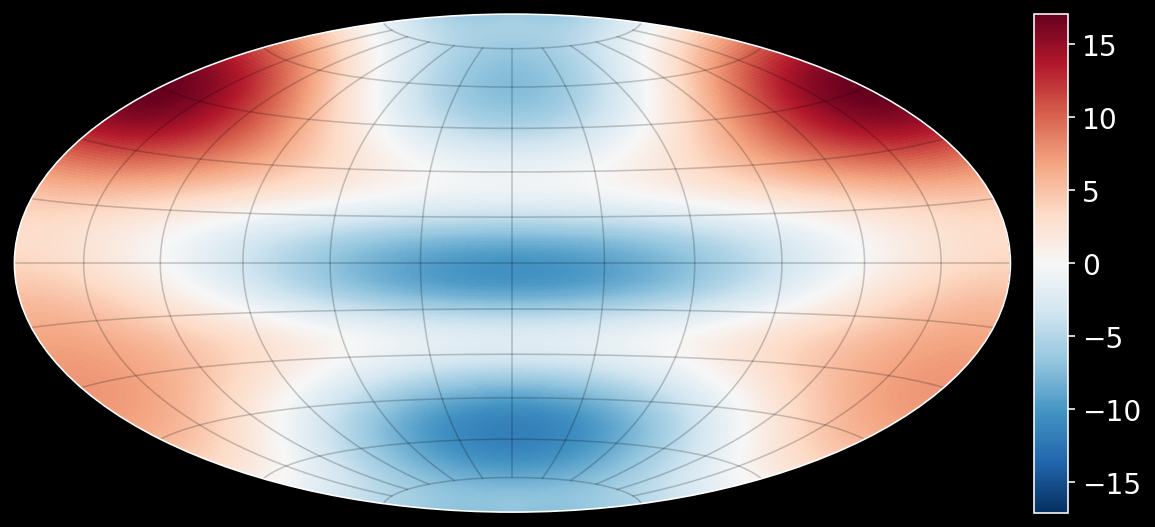

In [83]:
# Plot the initial conditions as functions on the sphere
# using the Hammer projection
im0 = qf.plot2(W0, projection='hammer', colorbar=True)

# Extract max value (for same limits in later plotting)
vmax = np.abs(im0.get_array().ravel()).max()

# Define the flows
Here we define the generator $P$ for the three flows defined above.

In [45]:
# Define the diagonal matrix V with entries from -i to i
# (it corresponds to the height function z which is the 
# spherical harmonic with l=1 and m=0)
V = qf.shr2mat(np.array([0,0,1,0]), N=N)

# The commutator needs to be scaled in order to keep
# the time-step independent of N
comm_scale = qf.seconds2qtime(1.0, N=N)

def toda(W):
    X = qf.commutator(V, W)
    X *= -comm_scale # Minus to get negative gradient flow
    
    # The tridiagonal invariant subspace for the toda flow is
    # not numerically stable, so we need to enforce it to avoid
    # drifting off the invariant subspace
    X = np.triu(np.tril(X, 1), -1)

    return X

def ipm(W):
    Y = qf.commutator(V, W)
    Y *= comm_scale
    X = qf.solve_poisson(Y) # IPM type flow so Laplace inverse
    return X

useipm = True
def diagflow(W):
    # Extract diagonal part of W
    D = np.diag(np.diag(W))

    Y = qf.commutator(D, W)
    Y *= comm_scale

    if not useipm:
        X = Y # Toda-version
    else:
        X = qf.solve_poisson(Y) # IPM-version so Laplace inverse
    return X

# Specify individual time scalings between the flows
# (so that the same time-step can be used for each)
flows = {"toda":toda, "ipm":ipm, "diag":diagflow}
scales = dict()
for simkey in flows:
    Ptest = flows[simkey](W0)

    # Scale by spectral norm, which indicate
    # how fast the linearized dynamics is
    scales[simkey] = np.linalg.norm(Ptest, ord=2)

# Manual fix to scale Toda correctly
scales['toda'] *= 3


# Run simulations

In [48]:
# Identifiers for the flow
simkeys = ["toda","ipm","diag"]
sims = dict()

# Batch prefix to be added to filename
prefix = None

# Total number of steps
total_steps = 250

# How many steps to take between out steps
inner_steps = 4

# Run simulation for each flow
for simkey in simkeys:

    flow, scale = flows[simkey], scales[simkey]

    # Out file name
    filedir = "simulations"
    filename = "gradient_flow_N_{}_{}{}.hdf5".format(N, simkey, 
                '' if prefix is None else '_'+prefix)
    filename = os.path.join(filedir, filename)
    
    # The time step
    epsilon = 0.5/scale

    # Callback data object
    qusim = qf.QuData(filename)
    sims[simkey] = qusim

    # Save initial conditions if file does not exist already, 
    # otherwise load from last step
    try:
        f = h5py.File(filename, "r")
    except IOError or KeyError:
        # Start from initial data
        W = W0.copy()

        # Add initial conditions to out file
        qusim(W, 0.0)
    else:
        # Start from last step in out file
        W = qf.shr2mat(f['state'][-1, :])
        W0 = qf.shr2mat(f['state'][0, :])
        f.close()

    # Run simulation
    if total_steps > 0:
        qf.solve(W, 
                qstepsize=epsilon, 
                steps=total_steps, 
                inner_steps=inner_steps, 
                # method=qf.isomp,
                callback=qusim,
                method_kwargs={'hamiltonian': flow})

    # Flush cache data
    qusim.flush()

  0%|          | 0/250 [00:00<?, ? steps/s]

  0%|          | 0/250 [00:00<?, ? steps/s]

  0%|          | 0/250 [00:00<?, ? steps/s]

# Plot the results

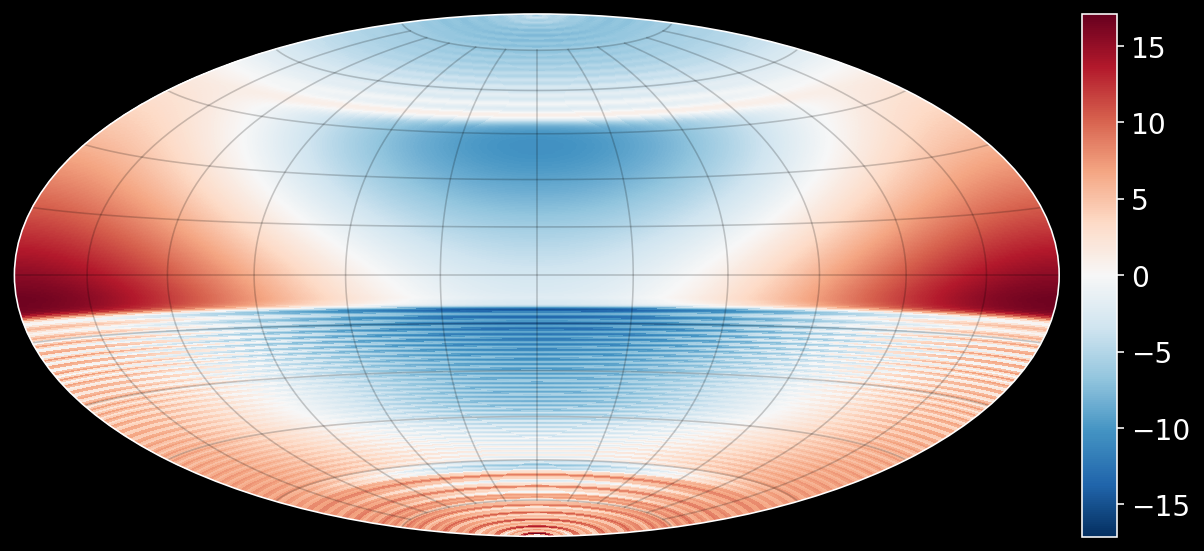

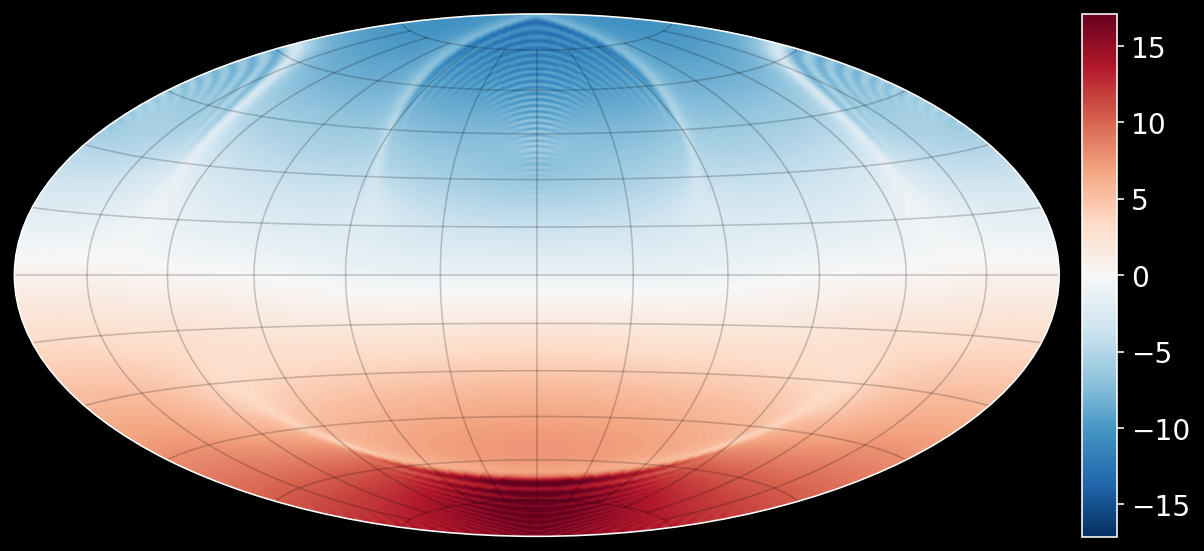

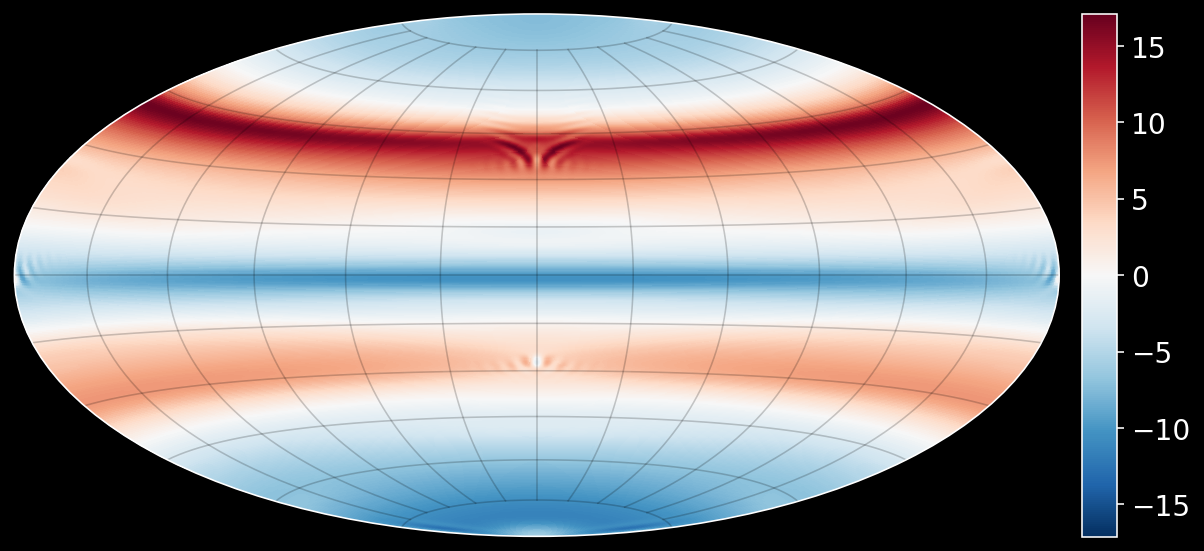

In [84]:
with plt.rc_context({'figure.figsize':(8,5)}):
    figs = dict()
    for simkey, qusim in sims.items():
        
        # Open out file in context
        with h5py.File(qusim.filename, 'r') as data:

            # Extract last state
            omega = data['state'][-1]

            # Plot the state
            figs[simkey] = qf.plot2(omega, projection='hammer', 
                                    colorbar=True, N=512,
                                    vmin=-vmax, vmax=vmax)

## Save plots

In [85]:
figfolder = "images"
for simkey, fig in figs.items():
    figname = os.path.basename(sims[simkey].filename).replace("hdf5","png")
    figname = os.path.join(figfolder, figname)
    fig.figure.savefig(figname, transparent=True, bbox_inches='tight')

# Spy at the matrix elements

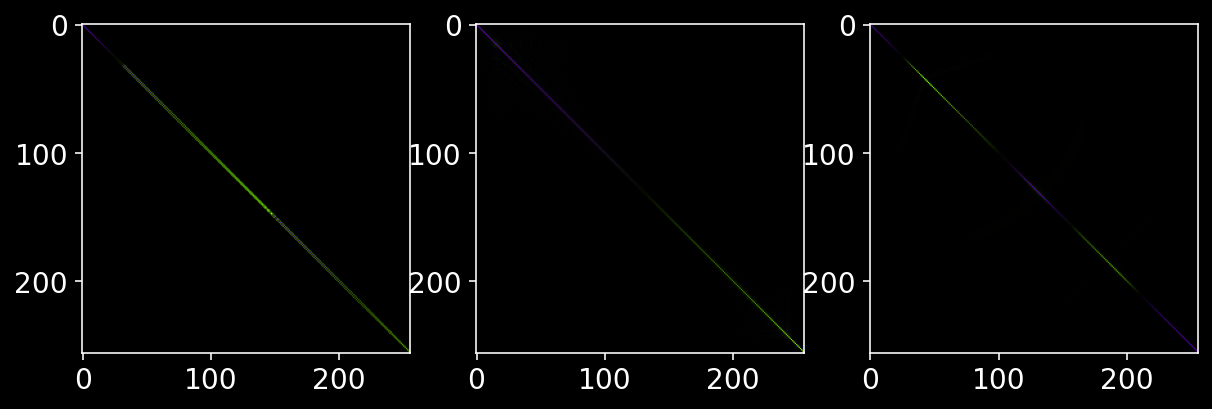

In [51]:
with plt.rc_context({'figure.figsize':(10,4)}):
    fig, axs = plt.subplots(ncols=len(sims), nrows=1)
    for (simky, qusim), ax in zip(sims.items(), axs):
        
        # Open out file in context
        with h5py.File(qusim.filename, 'r') as data:
            
            # Extract last state
            omega = data['state'][-1]

            # Convert back to matrix
            Wlast = qf.shr2mat(omega)

            # Spy at Wlast
            qf.spy(Wlast, ax=ax, colorbar=False)

# Animate the results

In [88]:
anims = dict()
animfolder = "movies"
animfiles = dict()
for simkey, qusim in sims.items():
    
    # Animation filename
    animfiles[simkey] = os.path.basename(sims[simkey].filename).replace("hdf5","mp4")
    animfiles[simkey] = os.path.join(animfolder, animfiles[simkey])

    # Open out file in context
    with h5py.File(qusim.filename, 'r') as data:

        # Create animation
        anim = qf.create_animation2(animfiles[simkey], 
                                    data['state'],
                                    projection='hammer', N=256)
        anims[simkey] = anim

  0%|          | 0/142 [00:00<?, ? frames/s]

  0%|          | 0/142 [00:00<?, ? frames/s]

  0%|          | 0/142 [00:00<?, ? frames/s]

In [89]:
from IPython.display import Video
Video(animfiles['toda'], embed=True)

In [90]:
Video(animfiles['ipm'], embed=True)

In [91]:
Video(animfiles['diag'], embed=True)

# Plot evolution of diagonal elements

In [56]:
diag_indices = [200, 150, 100, 50, 10]

# Extract diagonals
diag_arrays = {}
qtimes = {}
for simkey, qusim in sims.items():
    
    # Open out file in context
    with h5py.File(qusim.filename, 'r') as data:

        vals = []
        qtimes[simkey] = np.arange(data['qtime'].shape[0])*inner_steps
        for omega in data['state']:
            W = qf.shr2mat(omega)
            vals.append(np.diag(W)[diag_indices])
        diag_arrays[simkey] = np.array(vals)

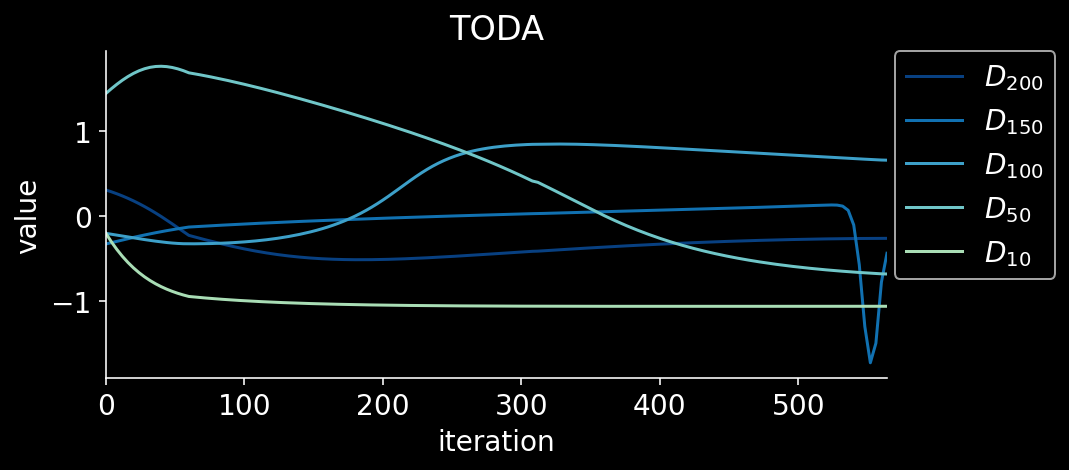

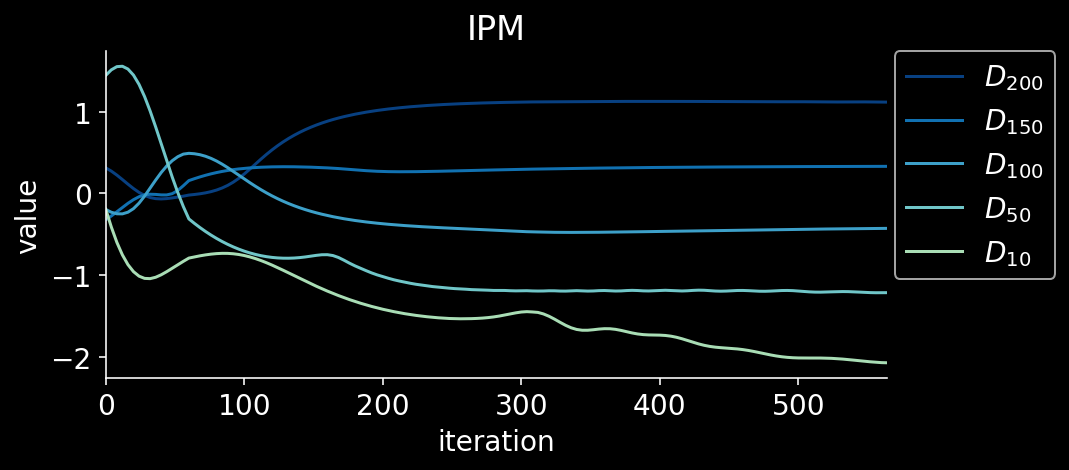

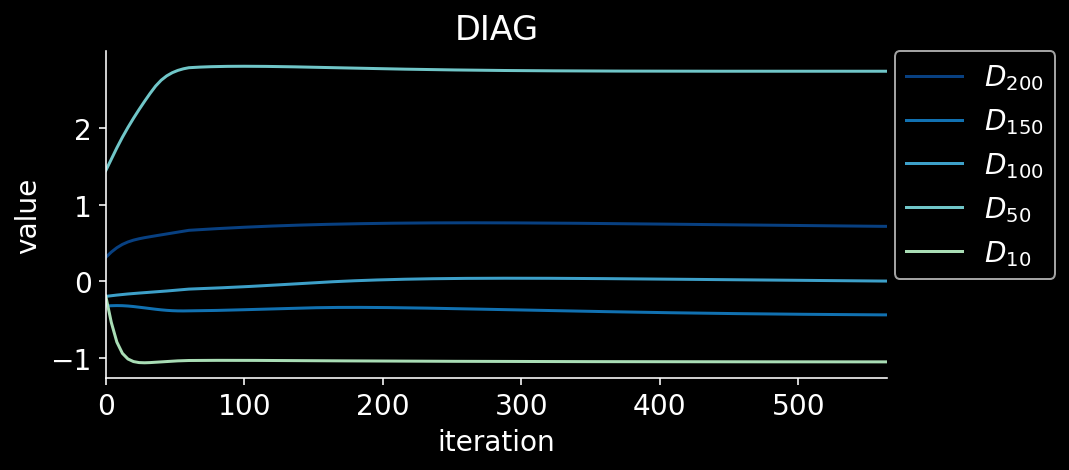

In [57]:
with plt.rc_context({'figure.figsize':(7,3)}):

    # Setup colors
    diag_colors = []
    # diag_cmap = plt.colormaps["tab20c"]
    diag_cmap = plt.colormaps["GnBu_r"]
    for k in range(len(diag_indices)):
        diag_colors.append(diag_cmap(k*40))

    # Plot diagonals
    diag_plots = dict()
    for simkey, diag_array in diag_arrays.items():
        dfig, dax = plt.subplots(ncols=1, nrows=1)
        for k in range(diag_array.shape[-1]):
            diag_plots[simkey] = dax.plot(qtimes[simkey], diag_array[:,k].imag, 
                                            color=diag_colors[k],
                                            label=r"$D_{k}$".replace("k",str(diag_indices[k])))[0]
        dax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        dax.set_title(simkey.upper())
        dax.set_xlim((0,round(1.0*qtimes[simkey][-1])))
        dax.set_xlabel('iteration')
        dax.set_ylabel('value')
        dax.spines['top'].set_visible(False)
        dax.spines['right'].set_visible(False)

## Save plots

In [96]:
try:
    x = figfolder
except:
    figfolder = "images"
for simkey, pl in diag_plots.items():
    dfigname = os.path.basename(sims[simkey].filename).replace(".hdf5","_diagonals.png")
    dfigname = os.path.join(figfolder, dfigname)
    pl.figure.savefig(dfigname, transparent=True, bbox_inches='tight')

# Compare with exact spectrum

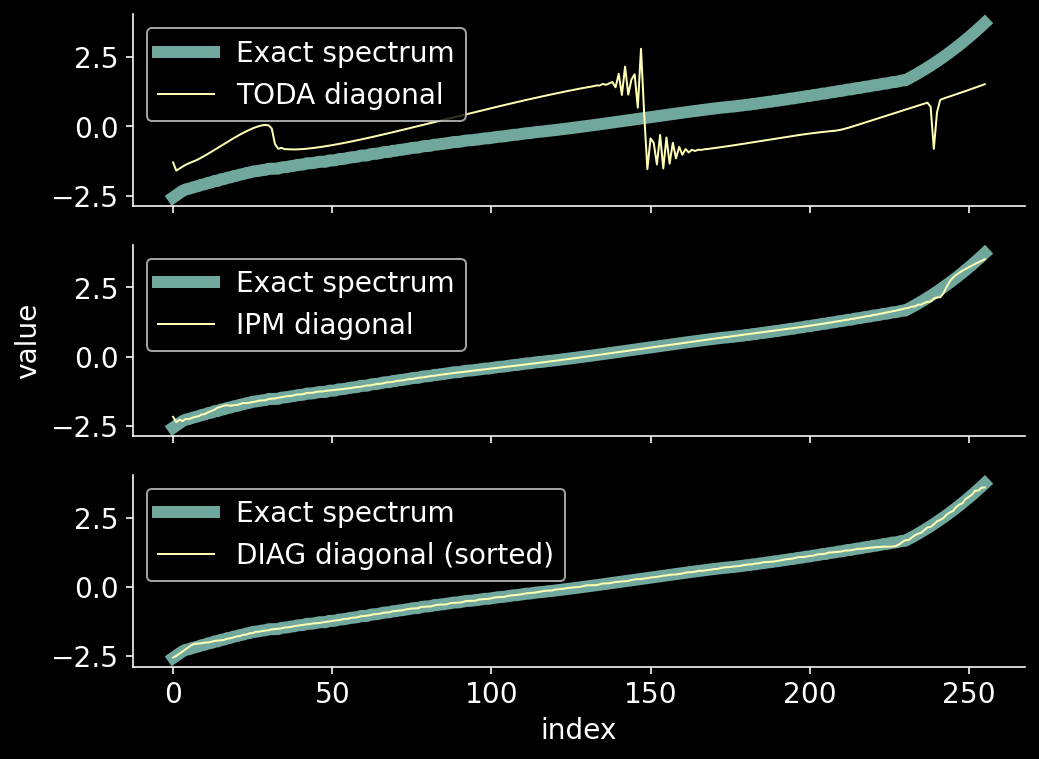

In [93]:
with plt.rc_context({'figure.figsize':(8,6)}):
    spec_plots = dict()
    # fig, axs = plt.subplots(nrows=1, ncols=len(sims), sharex=False, sharey=True)
    spec_fig, axs = plt.subplots(nrows=len(sims), ncols=1, sharex=True, sharey=False)

    C0 = 'C0'
    C1 = 'C1'

    for (simkey, qusim), sax, k in zip(sims.items(), axs, range(len(sims))):
        
        # Open out file in context
        with h5py.File(qusim.filename, 'r') as data:

            # Labels
            exact_label = "Exact spectrum"
            spec_label = "{} diagonal".format(simkey.upper())

            # Compute exact spectrum
            spec_exact = -np.linalg.eigvalsh(1j*qf.shr2mat(data['state'][0]))[::-1]

            # Extract approximate spectrum from last state
            spec = np.diag(qf.shr2mat(data['state'][-1])).imag
            if "diag" in simkey:
                spec = np.sort(spec)
                spec_label += " (sorted)"

            # Plot the state
            # spec_fig, sax = plt.subplots(ncols=1, nrows=1)
            spec_plots[simkey] = sax.plot(spec_exact, linewidth=6, alpha=0.8, 
                                        color=C0, label=exact_label)[0]
            sax.plot(spec, linewidth=1, alpha=1, color=C1, label=spec_label)
            # sax.set_title(simkey.upper())
            sax.legend(loc='upper left')
            if 'ipm' in simkey:
                sax.set_ylabel('value')
            if 'diag' in simkey:
                sax.set_xlabel('index')
            sax.spines['top'].set_visible(False)
            sax.spines['right'].set_visible(False)
            # sax.set_xlim((0,None))
            

## Save spectrum figure

In [95]:
try:
    x = figfolder
except:
    figfolder = "images"
sfigname = os.path.basename(sims['toda'].filename).replace(".hdf5","_spectrum.png").replace("_toda","")
sfigname = os.path.join(figfolder, sfigname)
spec_plots['toda'].figure.savefig(sfigname, transparent=True, bbox_inches='tight')